In [18]:
import cv2
import numpy as np

# Load HAAR face classifier
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load functions
def face_extractor(img):
    # Function detects faces and returns the cropped face
    # If no face detected, it returns the input image
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return None
    
    # Crop all faces found
    for (x,y,w,h) in faces:
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

# Initialize Webcam
cap = cv2.VideoCapture(0)
count = 0

# Collect 100 samples of your face from webcam input
while True:

    ret, frame = cap.read()
    if face_extractor(frame) is not None:
        count += 1
        face = cv2.resize(face_extractor(frame), (400, 400))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

        # Save file in specified directory with unique name
        file_name_path = r'C:\Users\Lenovo\Desktop\Mlops_training\my_dataset\data\train' + str(count) + '.jpg'
        cv2.imwrite(file_name_path, face)

        # Put count on images and display live count
        cv2.putText(face, str(count), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Face Cropper', face)
        
    else:
        print("Face not found")
        pass

    if cv2.waitKey(1) == 13 : #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      
print("Collecting Samples Complete")

In [8]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

# Re-loads the VGG16 model without the top or FC layers
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

Using TensorFlow backend.


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [9]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [22]:
model.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs=model.input, outputs=FC_Head)

print(modelnew.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir =r'C:\Users\Lenovo\Desktop\Mlops_training\my_dataset\data\train'
validation_data_dir = r'C:\Users\Lenovo\Desktop\Mlops_training\my_dataset\data\test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
batch_size = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 637 images belonging to 2 classes.
Found 191 images belonging to 2 classes.


In [68]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("face_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 600
nb_validation_samples = 191
epochs = 3
batch_size = 16

history = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

modelnew.save("face_vgg.h5")

Epoch 1/3
37/37 [==============================] - 188s 5s/step - loss: 0.2632 - accuracy: 0.9297 - val_loss: 0.0725 - val_accuracy: 0.9909

Epoch 00001: val_loss improved from inf to 0.07251, saving model to face_vgg.h5
Epoch 2/3
37/37 [==============================] - 151s 4s/step - loss: 0.1370 - accuracy: 0.9591 - val_loss: 0.0265 - val_accuracy: 0.9802

Epoch 00002: val_loss improved from 0.07251 to 0.02653, saving model to face_vgg.h5
Epoch 3/3
37/37 [==============================] - 155s 4s/step - loss: 0.1848 - accuracy: 0.9428 - val_loss: 0.1047 - val_accuracy: 0.9818

Epoch 00003: val_loss did not improve from 0.02653


In [69]:
train_generator.class_indices

{'hvk': 0, 'jalaj': 1}

In [106]:
from keras.models import load_model

h = load_model("face_vgg.h5")

from keras.preprocessing import image

my_img = image.load_img(r"C:\Users\Lenovo\Desktop\Mlops_training\my_dataset\data\test\hvk\img92.jpg",target_size=(224,224,3))

type(my_img)



PIL.Image.Image

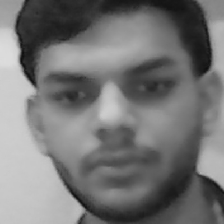

In [107]:
my_img



In [108]:
my_img = image.img_to_array(my_img)

import numpy as np

hvk_img = np.expand_dims(my_img,axis=0)

In [109]:
hvk_img.shape

(1, 224, 224, 3)

In [110]:
result = h.predict(hvk_img)

In [111]:
result

array([[2.226596e-27, 1.000000e+00]], dtype=float32)

In [100]:
from keras.models import load_model

h = load_model("face_vgg.h5")

from keras.preprocessing import image

my_img = image.load_img(r"C:\Users\Lenovo\Desktop\Mlops_training\my_dataset\data\test\hvk\img1.jpg",target_size=(224,224,3))

type(my_img)

PIL.Image.Image

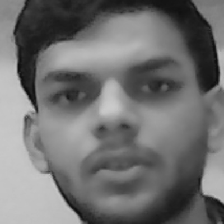

In [101]:
my_img

In [102]:
my_img = image.img_to_array(my_img)

import numpy as np

hvk_img = np.expand_dims(my_img,axis=0)

In [103]:
hvk_img.shape

(1, 224, 224, 3)

In [104]:
result = h.predict(hvk_img)

In [105]:
result

array([[5.677772e-19, 1.000000e+00]], dtype=float32)